In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

%matplotlib inline

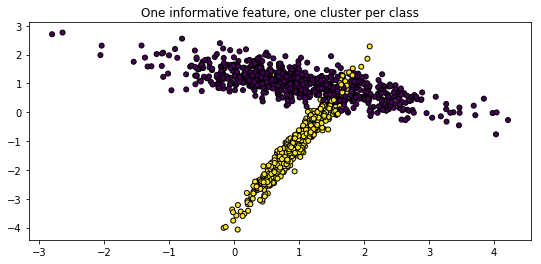

In [2]:
plt.figure(figsize=(9, 4))
plt.title("One informative feature, one cluster per class")
X, y = make_classification(n_samples=1500, n_features=2, n_classes=2,
                               n_redundant=0, n_informative=2, n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
class MultiLayerPerceptron():
    
    def __init__(self, X, y, activation='sigmoid'):
        self.X = X
        self.y = np.array([y])
        
        # weights
        self._W1 = np.random.rand(8, 2) * np.sqrt(2/(8 + 2))
        self._B1 = np.zeros((8, 1))
        self._W2 = np.random.rand(1, 8) * np.sqrt(2/(8 + 1))
        self._B2 = np.zeros((1, 1))
        
        # layers
        self._l0 = self.X.copy()
        self._l1 = np.zeros((self._W1.shape[1], self._l0.shape[1]))
        self._l2 = np.zeros((self._W2.shape[1], self._l1.shape[1]))
    
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        else:
            self._activation = self._relu
    
    def _sigmoid(self, Z, deriv=False):
        if deriv == True:
            return Z * (1 - Z)
        return 1 / (1 + np.exp(-Z))
    
    def _relu(self, Z, deriv=False):
        if deriv == True:
            return np.where(Z > 0, 1, 0)
        return np.maximum(0, Z)
    
    def _mse(self, Yh):
        return np.sum(Yh**2)

    def forward(self, Z):
        self._l1 = np.dot(self._W1, Z) + self._B1
        self._a1 = self._activation(self._l1)
        self._l2 = np.dot(self._W2, self._a1) + self._B2
        self._a2 = self._activation(self._l2)
        return self._a2
    
    def h_backprop(self, delta, weight, layer):
        error = np.dot(weight.T, delta)
        delta = error * self._activation(layer, deriv=True)
        return delta
    
    def backward(self, lr):
        E = self.y - self._a2
        grad_l2 = E * self._activation(self._a2, deriv=True)
        E_prev = np.dot(self._W2.T, grad_l2)
        grad_l1 = E_prev * self._activation(self._a1, deriv=True)    
        
        self._W2 += lr * np.dot(grad_l2, self._a1.T)
        self._B2 += lr * np.sum(grad_l2)
        self._W1 += lr * np.dot(grad_l1, self._l0.T)
        self._B1 += lr * np.sum(grad_l1)
        return E
    
    def train(self, epochs=2500, lr=1e-3):
        error_step = []
        total_expected_error = 0
        for epoch in range(epochs):
            self.forward(self.X)
            E = self.backward(lr)
            total_error = self._mse(E)
            if np.abs(total_expected_error-total_error) < 1e-15:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)    
        return np.array(error_step)
    
    def predict(self, Z):
        return self.forward(Z)

Acurácia: 91.78%
Acurácia: 90.89%
Acurácia: 91.33%
Acurácia: 90.89%
Acurácia: 90.89%


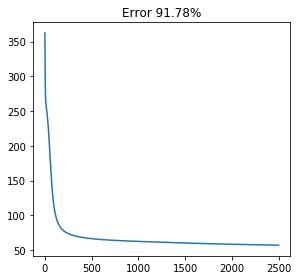

In [28]:
final_error = None
better_acc = 0

for _ in range(5):
    md = MultiLayerPerceptron(X_train.copy().T, y_train.copy().T)
    error = md.train()
    predYm = np.where(md.predict(X_test.copy().T)[0] > .5, 1, 0)
    acc = np.round((np.sum(predYm == y_test) / len(y_test)) * 100, 2)
    if acc > better_acc:
        final_error = error
        better_acc = acc
    print(f'Acurácia: {acc}%')

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

In [29]:
for _ in range(5):
    clf = MLPClassifier(max_iter=2500, tol=1e-3, alpha=1e-3)
    clf.fit(X_train, y_train)
    print(f'Acurácia: {np.round(clf.score(X_test, y_test) * 100, 2)}%')

Acurácia: 91.11%
Acurácia: 92.0%
Acurácia: 92.22%
Acurácia: 90.89%
Acurácia: 92.22%
